# Homework 4

In this homework we will practice basic analysis such as feature extraction and data transforms (Fourier, wavelet), and feature extraction.


**1. Ice-shelf seismograms** (10 points)

Time-domain filtering, 1D Fourier transform.

**2. TEC from the Hunga-Tunga explosion** (10 points)

Time-domain filtering, 1D wavelet transform.

**3. 2D Crustal model** (10 points)

practice reading netcdf, making maps and exploring 2D spectral content.



In [4]:
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import scipy
import scipy.signal as signal

## 1) Time Frequency analysis of iceshelf vibrations 

We will explore the spectral content of the vibrations felt on iceshelves. We first download seismic data, then filter it at different frequency bandwidths, then plot the spectrogram and comment on the data.

The seismic data is handled by the Obspy package. Review the obspy tutorial that Ariane.
We will download the data presented in: Aster, R.C., Lipovsky, B.P., Cole, H.M., Bromirski, P.D., Gerstoft, P., Nyblade, A., Wiens, D.A. and Stephen, R., 2021. Swell‐Triggered Seismicity at the Near‐Front Damage Zone of the Ross Ice Shelf. Seismological Research Letters. https://doi.org/10.1785/0220200478

__Tips__:
1. Check out the SciPy filtering help here: https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html. Obspy has built in functions as well, but for the sake of practicing, explore the scipy filtering functions.

2. The usual steps to handling seismic data are: data download (``get_waveforms``) & removing the instrumental response (``remove_response``).




**a. Import the relevant Obspy python modules (1 point).**

In [2]:
# Import the Obspy modules that will be useful to download seismic data
import obspy
import obspy.clients.fdsn.client as fdsn
from obspy import UTCDateTime

**b. Data download (1 point)**

We will now download the data from station "DR01" from seismic network "XH", channel "LHN" from 1/1/2015 until 3/31/2015. The client will be the "IRIS" data center. Obspy functions take on UTCDateTime formatted obspy datetime object, be sure to call or import that specific function. (1 point)

In [3]:
# answer below
# Download seismic data
network = 'XH'
station = 'DR01'
channel = 'LHN'
Tstart = UTCDateTime(2015,1,1,0,0)
Tend = UTCDateTime(2015,3,31,0,0)
fdsn_client = fdsn.Client('IRIS') # client to query the IRIS DMC server

# call to download the specific data: earthquake waveforms
Z = fdsn_client.get_waveforms(network=network, station=station, location='--', channel=channel, starttime=Tstart, \
    endtime=Tend, attach_response=True)
# basic pre-processing: merge all data if there is gaps, detrend, taper,
#  remove the seismic instrumental response to go from the digitizer units to ground motion (velocity) units.
Z.merge(); Z.detrend(type='linear'); Z[0].taper(max_percentage=0.05);Z[0].remove_response()


XH.DR01..LHN | 2015-01-01T00:00:00.000000Z - 2015-03-31T00:00:00.000000Z | 1.0 Hz, 7689601 samples

In [4]:
# how many days did we download?
dt=Tend-Tstart # in seconds
Ndays = int(dt/86400) # in days
print(Ndays)

89


**c. Time series filtering (2 points)**

Now we will filter the trace to explore its frequency content. We will apply 3 filters:
1. a ``lowpass`` filter to look at seismic frequencies below 0.01Hz, or 100 s period

2. a ``bandpass`` filter to look at seismic frequencies between 0.01Hz-0.1 Hz (10-100s)

3. a ``highpass`` filter to look at seismic frequencies higher than 0.1 Hz (10s) and until the time series Nyquist frequency (0.5Hz since the data is sampled at 1 Hz).

In [4]:
# answer below
from scipy.signal import butter,buttord,  sosfiltfilt, freqs

# sampling rate of the data:
fs = Z[0].stats.sampling_rate
z=np.asarray(Z[0].data)

# lowpass
sos = signal.butter(2, 0.01, 'lowpass', fs=fs, output='sos')
z_lp = signal.sosfilt(sos, z)

# bandpass
sos = signal.butter(2, [0.01, 0.1], 'bandpass', fs=fs, output='sos')
z_bp = signal.sosfilt(sos, z)

# highpass
sos = signal.butter(2, 0.1, 'highpass', fs=fs, output='sos')
z_hp = signal.sosfilt(sos, z)

# Here we use a Butterworth filter to select the spectral content of the waveform. 
# I like to use Buttord because it finds the order of the filter that meets the amplitude reduction criterion
# it's a lot more intuitive! https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.buttord.html


**c. Fourier transform (3 points)**


Perform and the Fourier amplitude spectrum of the seismogram. Don't forget to label the figure properly! Use the Fourier frequency vector for x-axis. Use the tutorials for inspirtion.

In [6]:
Z[0].data

array([-1.53816648e-07, -1.53836952e-07, -1.53867990e-07, ...,
       -7.24608988e-08, -7.23555631e-08, -7.22549760e-08])

In [5]:
# import FFT modules
from scipy.fftpack import fft, ifft, fftfreq, next_fast_len
# answer below
npts = Z[0].stats.npts

# fill up until 2^N value to speed up the FFT
Nfft = next_fast_len(int(Z[0].data.shape[0])) # this will be an even number
freqVec = fftfreq(Nfft, d=Z[0].stats.delta)[:Nfft//2]
Z.taper(max_percentage=0.05)
Zhat = fft(Z[0].data,n=Nfft)#/np.sqrt(Z[0].stats.npts)

# filtered data with 3 types
z_lp_hat = fft(z_lp,n=Nfft)
z_bp_hat = fft(z_bp,n=Nfft)#/np.sqrt(Z[0].stats.npts)
z_hp_hat = fft(z_hp,n=Nfft)

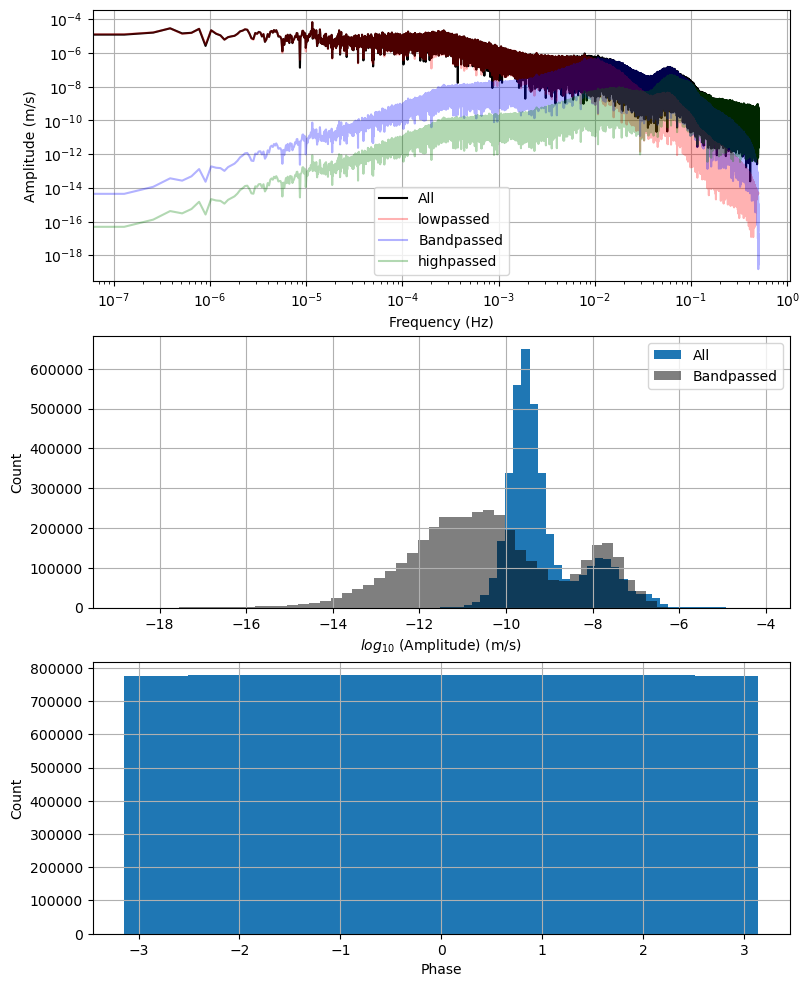

In [11]:
fig,ax=plt.subplots(3,1,figsize=(9,12))

# amplitude spectra
ax[0].plot(freqVec,np.abs(Zhat[:Nfft//2])/Nfft, 'k') # original
ax[0].plot(freqVec,np.abs(z_lp_hat[:Nfft//2])/Nfft, alpha=0.3, color='r') # lowpassed
ax[0].plot(freqVec,np.abs(z_bp_hat[:Nfft//2])/Nfft, alpha=0.3, color='b') # bandpassed
ax[0].plot(freqVec,np.abs(z_hp_hat[:Nfft//2])/Nfft, alpha=0.3, color='g') # highpassed
ax[0].grid(True)
ax[0].set_xscale('log');ax[0].set_yscale('log')
ax[0].set_xlabel('Frequency (Hz)');ax[0].set_ylabel('Amplitude (m/s)')
ax[0].legend(['All','lowpassed','Bandpassed','highpassed'])

# distribution of the amplitude value
ax[1].hist(np.log10(np.abs(Zhat[:Nfft//2])/Nfft),50)
ax[1].hist(np.log10(np.abs(z_bp_hat[:Nfft//2])/Nfft),50, alpha=0.5, color='k')
ax[1].set_xlabel('$log_{10}$ (Amplitude) (m/s)')
ax[1].set_ylabel('Count')
ax[1].legend(['All','Bandpassed'])
ax[1].grid(True)

# distribution of the phase value
ax[2].hist(np.angle(Zhat))
ax[2].set_xlabel('Phase')
ax[2].set_ylabel('Count')
ax[2].grid(True)

Comment on the spectral content of the seismograms. How does the relative contribution of the low, intermediate, and high frequency signal compares with the relative amplitude observed in the bandpass filtered time series?

The spectral of the bandpass filtered time series has exact amlitude at the range of the frequency between 0.01Hz and 0.1 Hz. Outside the frequency range, i.e., low frequency (<0.01 Hz) and high frequency (> 0.1 Hz) have lower amplitude comparing to the spectral from original time series data.

**d. Synthetic noise (3 points)**

We have now a good idea of what the amplitude of seismic waves are at this station. Now create a noise signal using the Fourier amplitude spectrum of the seismic signal, and with a random phase. You can use the notes from our first Numpy example (2.7_data_transforms.ipynb)

In [20]:
from scipy.fftpack import ifft
from numpy import random

Nfft = next_fast_len(int(Z[0].data.shape[0]-1)) # this will be an even number
NN = 2*np.pi*random.uniform(-1,1,Nfft//2)-np.pi # make random phase
noise=np.zeros(Nfft,dtype=np.complex_) # create empty variable

for i in range(Nfft//2):
    noise[i] = np.abs(Zhat[i])*np.exp(1j*NN[i]) # same amplitude of signal but with random noise

crap = ifft(noise)

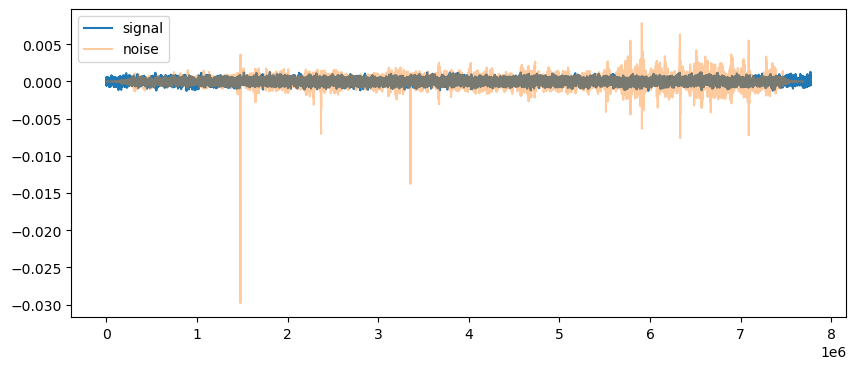

In [23]:
# look at the time series
plt.figure(figsize=(10,4))
plt.plot(crap)
plt.plot(Z[0].data, alpha =0.4)
plt.legend(['signal','noise'])

**e. !Sanity check! (1 point)**

Check that the Fourier amplitude spectrum of the noise is that of the original window. Overlay them on a plot 

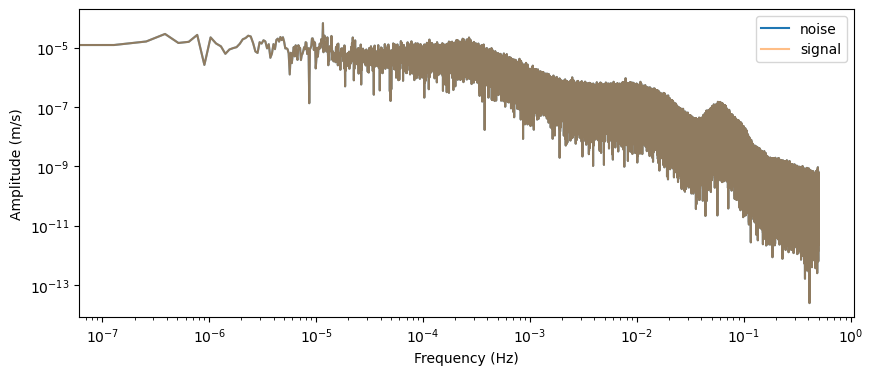

In [24]:
plt.figure(figsize=(10,4))
# noise
plt.plot(freqVec,np.abs(noise[:Nfft//2])/Nfft)
# original signal
plt.plot(freqVec,np.abs(Zhat[:Nfft//2])/Nfft, alpha=0.5)
plt.xscale('log');plt.yscale('log')
plt.xlabel('Frequency (Hz)'); plt.ylabel('Amplitude (m/s)')
plt.legend(['noise','signal'])

# they are fully overlapped, which means good! they are really with same amplitude

**f. Short Time Fourier Transform (3 points)**

STFT are important transforms that are used in data science of time series. They are mainly used for denoising and for feature extraction.
Spectrograms are STFT with window overlap.

In [25]:
# answer below
from scipy.signal import stft

nperseg=1000
z=np.asarray(Z[0].data)
f, t, Zxx = stft(z, fs=100, nperseg=nperseg,noverlap=200)
print(np.max(np.max(np.abs(Zxx))))

0.02310651781278415


/Users/jcai/miniconda3/envs/argo/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


Text(0.5, 0, 'Time [Hours]')

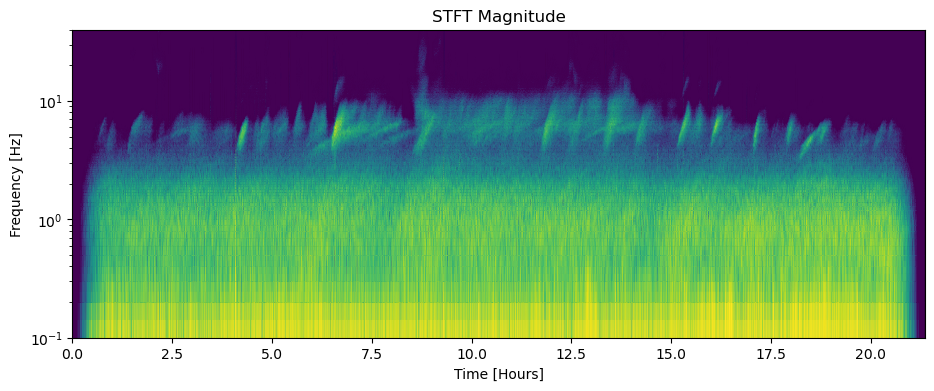

In [30]:
fig,ax=plt.subplots(1,1,figsize=(11,4),sharex=True)
ax.pcolormesh(t/3600, f, np.log10(np.abs(Zxx)), vmin=-7, vmax=-4, shading='gouraud')
ax.set_title('STFT Magnitude')
ax.set_ylabel('Frequency [Hz]')
ax.set_yscale('log');
ax.set_ylim(0.1,40)
ax.set_ylabel('Frequency [Hz]')
ax.set_xlabel('Time [Hours]')

Now you have created a 2D image of a time series! Many seismologists use that as input to convolutional neural networks.



## 2. Time Series analysis of Hunga- Tonga
 Ghent and Crowell, 2022: TF representation of the TEC (https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2022GL100145). The Total Electron Content (TEC) is the total number of electrons present along a path between a radio transmitter and receiver. TEC is measured in electrons per square meter. By convention, 1 TEC Unit TECU = 10^16 electrons/m². Vertical TEC values in Earth’s ionosphere can range from a few to several hundred TECU.

 On 15 January 2022, Tonga's Hunga Tonga-Hunga Ha'apai (HTHH) volcano violently erupted, generating a tsunami that killed three people. Acoustic-gravity waves propagated by the eruption and tsunami caused global complex ionospheric disturbances. In this paper, we study the nature of these perturbations from Global Navigation Satellite System observables over the southwestern Pacific. After processing data from 818 ground stations, we detect supersonic acoustic waves, Lamb waves, and tsunamis, with filtered magnitudes between 1 and 7 Total Electron Content units.

Apply the Fourier and Wavelet transforms to the TEC time series observed a a GPS section..


### a. Read the data (1 point)

Read the CSV file file ``./TEC/ioncorr_samo_015_2022_tonga.csv``, print the keys of the data frame. THe key ``time`` is a timestamp of seconds since epoch time (1970/01/01). The data shown in the article is in the Series ``variometric_derived_TEC``. **samo** is the name of the GPS receiver. There are up to 32 satellite data saved in the CSV file.

Plot the first 2 hours of the time series

In [5]:
# answer below
file = "./TEC/ioncorr_samo_015_2022_tonga.csv"
df = pd.read_csv(file)

In [6]:
df.keys()

Index(['Unnamed: 0', 'GPS_seconds', 'satellite_number',
       'variometric_derived_TEC', 'variometric_derived_TEC_filtered',
       'absolute_derived_TEC', 'absolute_derived_TEC_filtered',
       'latitude_piercing_point', 'longitude_piercing_point',
       'satellite_azimuth', 'satellite_elevation_angle',
       'distance_to_piercing_point', 'time'],
      dtype='object')

In [7]:
start = df.time[0]
end = start + 2*60*60 #first 2 hours

In [34]:
# convert seconds to datetime
# df.time = pd.to_datetime(df.time, unit='s') # origin is 1970/01/01

Text(0, 0.5, 'TECu')

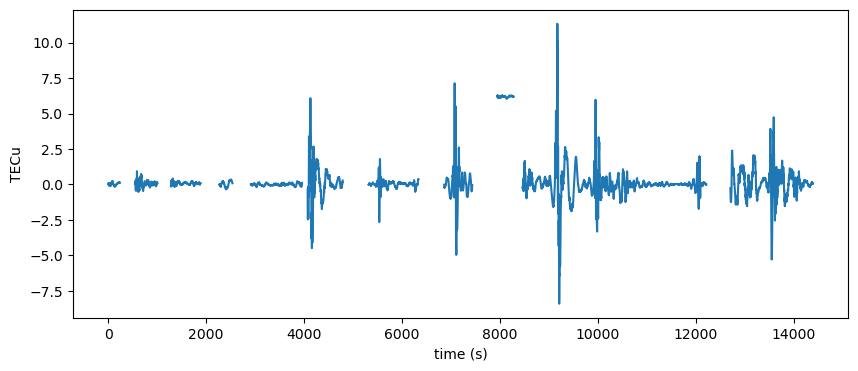

In [38]:
plt.figure(figsize=(10,4))
plt.plot(df.variometric_derived_TEC.where(df.time < end))
plt.xlabel('time (s)')
plt.ylabel('TECu')

## b. Get station info (0.5 point)
Get the station name by splitting the string of the file name and getting the charcater after "ioncorr". You can use the python function ``split()``.

In [39]:
# answer below
file.split('_')[1]

'samo'

## c. Plot all data (2 points)
Make a plot of all vTEC filtered (``variometric_derived_TEC_filtered``) for each satellite. Align the data with the satellite number.

Use the ``plot_date`` function from matplotlib. Convert the Series ``time`` from a ``timestamp`` to an Numpy array of dtpe ``datetime64[s]`` (time stamps are in seconds, so we need to use ``[s]``). Plot the data for each sattelite observations.

In [10]:
df.time.to_numpy()

array([1.64228622e+09, 1.64228625e+09, 1.64228628e+09, ...,
       1.64227731e+09, 1.64227734e+09, 1.64227737e+09])

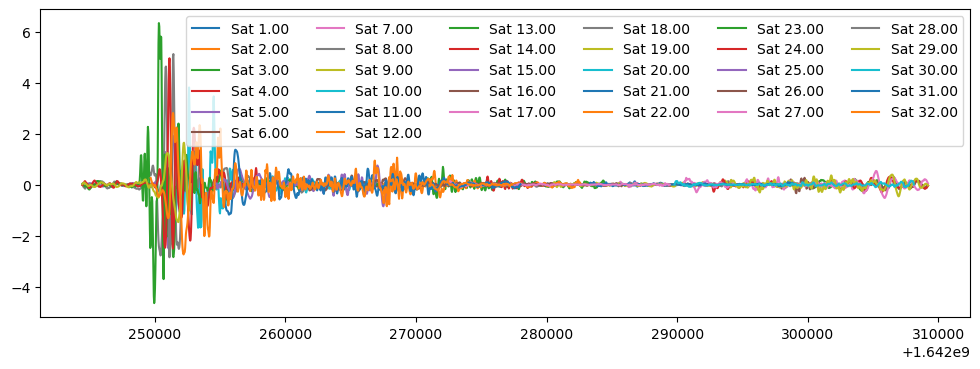

In [8]:
length = np.zeros(32)

plt.figure(figsize=(12,4))

for i in range(32):
    sat = i+1
    mask = df.satellite_number == sat
    plt.plot(df.time[mask], df.variometric_derived_TEC_filtered[mask], label="Sat %.2f" %sat)
    length[i] = len(df.time[mask])

    
plt.legend(ncol=6)
plt.show()

In [41]:
length # seems that satellite 32 got the longest time series

array([545.,   0., 735., 603.,   0., 388., 641., 613., 547., 691.,   0.,
         0.,   0., 552., 260., 658., 628., 573., 509.,   0., 521., 512.,
       754., 448., 440., 631., 567.,   0., 277., 612., 760., 924.])

In [49]:
df_32.index

Int64Index([13465, 13466, 13467, 13468, 13469, 13470, 13471, 13472, 13473,
            13474,
            ...
            14379, 14380, 14381, 14382, 14383, 14384, 14385, 14386, 14387,
            14388],
           dtype='int64', length=924)

Text(0, 0.5, 'TECu')

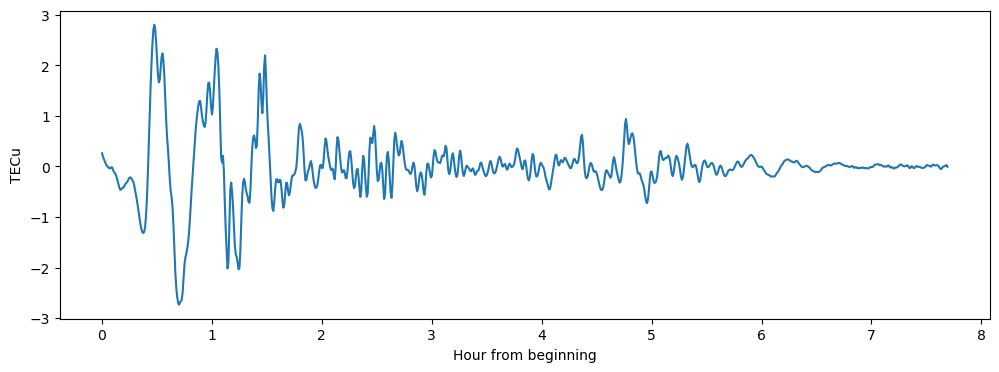

In [12]:
# choose. the 32nd satellite
df_32 = df[df.satellite_number==32]

plt.figure(figsize=(12,4))
plt.plot((df_32.time-df_32.time[df_32.index[0]])/60/60,df_32.variometric_derived_TEC_filtered) # convert the time series to hour from beginning
plt.xlabel('Hour from beginning');plt.ylabel('TECu')

You can now select one of the satellite observations that contain a full vTEC signal.

### d. Perform the wavelet transform (3 points)

Just like in the article, perform the wavelet transform using a Morlet transform. What can you tell about the time-frequency characteristic of these disturbances?

In [14]:
# answer below
import scipy.signal as signal

# use the number of scales
w = 6.
fs = 1/30 # frequency is sample every 30 seconds
freq = np.logspace(-1, np.log10(fs/2), 100)
widths = w*fs / (2*freq*np.pi)

cwtm = signal.cwt(df_32.variometric_derived_TEC_filtered, signal.morlet2, widths, w=w)

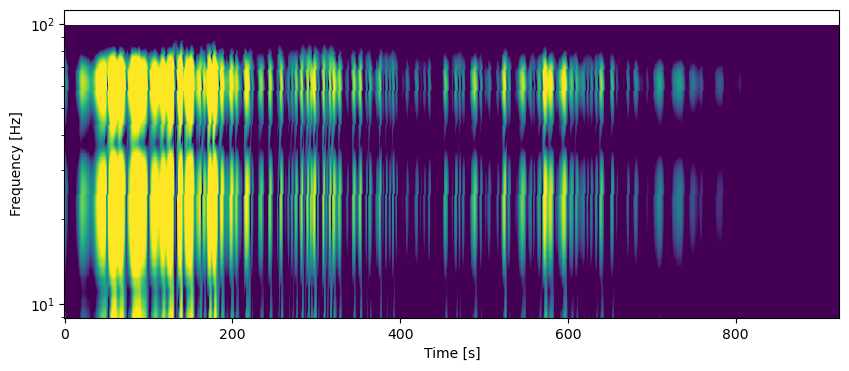

In [24]:
plt.figure(figsize=(10,4))
plt.imshow(np.log10(np.abs(cwtm)), cmap='viridis', vmax=0, vmin=-1, aspect='auto',origin='lower')
plt.yscale('log')
plt.xlabel('Time [s]');plt.ylabel('Frequency [Hz]')
plt.show()

From the wavelet transform above, there are two main frequency blocks,  i.e., high frequency (above 40 Hz) and low frequency (below 40 Hz). The signal is strongest at the begining 200 seconds, re-strenthen a few times before 600 seconds, and then finally fade out. 

Perform the wavelet transform.
Calculate the sampling frequency by taking the time difference between two samples.

In [11]:
#answer below
fs=df_32.time.values[1]-df_32.time.values[0]
fs

30.0

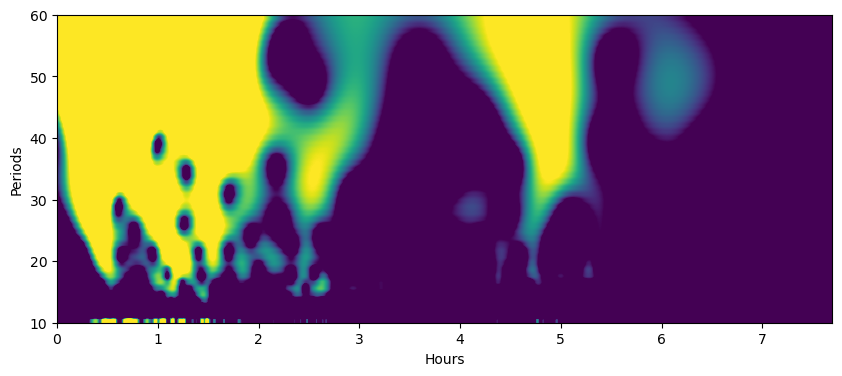

In [32]:
import scipy.signal as signal
# use the number of scales
w = range(1,50)

# answer below
t = df_32.time.values
cwtm2 = signal.cwt(df_32.variometric_derived_TEC_filtered, signal.morlet2, w)

plt.figure(figsize=(10,4))
plt.imshow(np.log10(np.abs(cwtm2)), extent=[0,(t.max()-t.min())/3600.,1./freq.max(),1./freq.min()], cmap='viridis', aspect='auto',
           vmax=0.1, vmin=-0.3,origin='lower')
plt.xlabel('Hours')
plt.ylabel('Periods')  
plt.show()

## e. Interpretation (0.5 points)
Can you describe the spectral features as a function of hours since the beginning of the time series? What periods dominate when?

From the wavelet transform above, The short-period waves (< 30 s) are only last during the first three hours while the long-period (> 40 s) waves are lasting longer till six hours. 

The authors interpret the first packet as coming from a Lamb wave (a powerful gravity-acoustic wave that travel in the lower atmosphere), the second as coming from the tsunami disturbance.

## 3) 2D Spectral analysis of geological models (10 points)

In this exercise we will correlate water table level with surface elevation. You may download the data just like in the class. The file names are ``NCM_GeologicFrameworksGrids.nc`` and ``NCM_SpatialGrid.nc``.


In the following we will prepare our data.

In [34]:
# ansert below
import netCDF4 as nc
import wget
import os


In [62]:
# Download the geological framework
file1 = wget.download("https://www.dropbox.com/s/wdb25puxh3u07dj/NCM_GeologicFrameworkGrids.nc?dl=1") #"./data/NCM_GeologicFrameworkGrids.nc"
# Download the coordinate grids
file2 = wget.download("https://www.dropbox.com/s/i6tv3ug15oe6yhe/NCM_SpatialGrid.nc?dl=1") #"./data/NCM_GeologicFrameworkGrids.nc"

100% [..................................................] 128818857 / 128818857

In [68]:
# Download the water table
file3 = wget.download("https://www.dropbox.com/s/92m20pehfu7rxp2/NCM_AuxData.nc?dl=1") #"./data/NCM_AuxData.nc"

100% [....................................................] 62906738 / 62906738

In [35]:
# read data
geology = nc.Dataset('NCM_GeologicFrameworkGrids.nc')
grid = nc.Dataset('NCM_SpatialGrid.nc')
Water = nc.Dataset('NCM_AuxData.nc')

In [36]:
print(geology.variables.keys())
print(Water.variables.keys())

dict_keys(['Notes', 'Surface Elevation', 'Bedrock Elevation', 'Bottom Cenozoic Elevation', 'Bottom Phanerozoic Elevation', 'Mid Crustal Elevation', 'Moho Elevation', 'Top Ocean Plate Elevation'])
dict_keys(['Water table depth file', 'Slopes file', 'Notes', 'Water Table Depth', 'Calibration Slope', 'Calibration Offset'])


**a. Plot (2 points)**

Plot the data ``WT`` and ``elevation``. Use ``contourf``,``x`` and ``y`` as lat-long variables. You can use ``levels``  to split the color map, and ``alpha`` less than 1 to increase transparency.

In [41]:
# answer below
# create a grid of latitude and longitude
x = grid['x'][0:4901, 0:3201]
y = grid['y'][0:4901, 0:3201]
elevation = geology['Surface Elevation'][0:4901, 0:3201]

WT = Water['Water Table Depth'][0:4901, 0:3201]

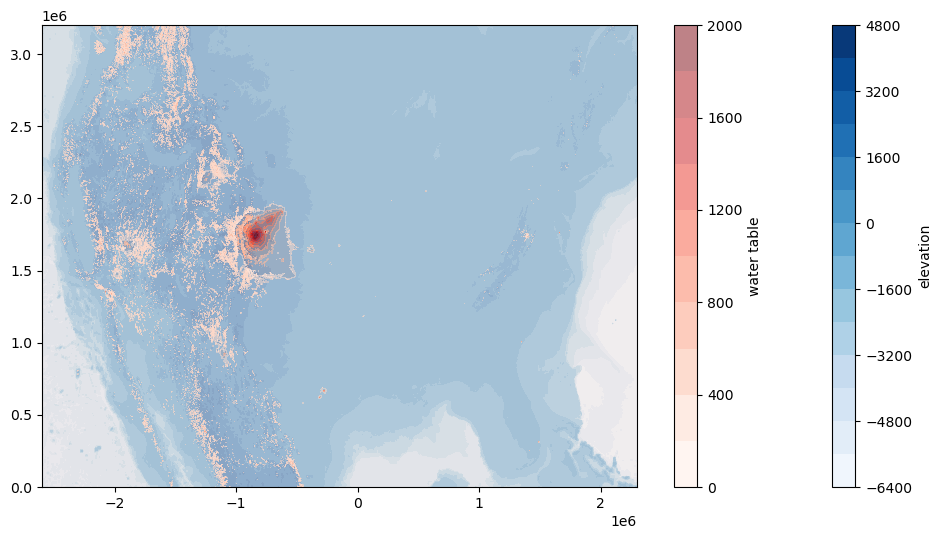

In [46]:
plt.figure(figsize=(12,6))

p1 = plt.contourf(x, y, elevation, levels=12, cmap="Blues")
cb1 = plt.colorbar(p1)
cb1.set_label('elevation')

p2 = plt.contourf(x, y, WT, levels=12, cmap="Reds", alpha=0.5)
cb2 = plt.colorbar(p2)
cb2.set_label('water table')


**b. Perform and plot the 2D Fourier transforms (4 points)**

In [48]:
# recreate the lat long vectors.
minlat,maxlat = min(grid['Latitude vector'][:]),max(grid['Latitude vector'][:])
minlon,maxlon = min(grid['Longitude vector'][:]),max(grid['Longitude vector'][:])
xlat = np.linspace(minlat,maxlat,3201)
xlon = np.linspace(minlon,maxlon,4901)

this is about the spatial sampling of the model  1.5007397612756534  km
this is about the spatial sampling of the model  1.0777344413103096  km


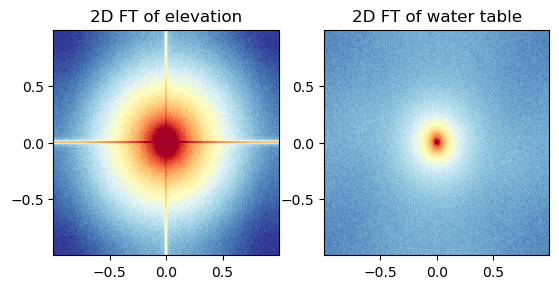

In [55]:
# answer below
from scipy.fftpack import fft2, fftfreq,fftshift
import matplotlib.cm as cm

Zel = fft2(elevation)
Zwt = fft2(WT)

# make the wavenumber frequency vector: 
Rlon = (xlon-np.min(xlon))*111.25  # convert degrees to kms
drlon = Rlon[1]-Rlon[0]
print("this is about the spatial sampling of the model ",drlon," km")
klon = (fftfreq( 4901//2 , drlon  ))


Rlat = (xlat-np.min(xlat))*111.25  # convert degrees to kms
drlat = Rlat[1]-Rlat[0]
print("this is about the spatial sampling of the model ",drlat," km")
klat = (fftfreq( 3201//2 , drlat  ))

fig, ax = plt.subplots(1,2) 

# amplitude of the DEM
ax[0].imshow(fftshift(np.log10(np.abs(Zel)/Zel.size)),vmin=-3, vmax=-1, cmap='RdYlBu_r',extent=[-1,1,-1,1])
ax[0].set_title('2D FT of elevation')
x_label_list = ['-1/3 km$^{-1}$','0','1/3  km$^{-1}$']
ax[0].set_xticks([-0.5,0,0.5])
ax[0].set_yticks([-0.5,0,0.5])

# amplitude of the water tabel
ax[1].imshow(fftshift(np.log10(np.abs(Zwt)/Zwt.size)),vmin=-3, vmax=-1, cmap='RdYlBu_r',extent=[-1,1,-1,1])
ax[1].set_title('2D FT of water table')
x_label_list = ['-1/3 km$^{-1}$','0','1/3  km$^{-1}$']
ax[1].set_xticks([-0.5,0,0.5])
ax[1].set_yticks([-0.5,0,0.5])
plt.show()

**c. Interpretation (1 point)**

Comment on the wavelengths that dominate the DEM and the water table wavelengths

The wavelengths dominate of the DEM are larger than the water tables

**d. 2D filtering (3 points)**

Find a way to low pass filter the image (spectral filtering or convolution)

In [57]:
# solution

import scipy.signal as signal
sos1 = signal.butter(2,0.01, btype='lp', output='sos')
Zel_lp = signal.sosfiltfilt(sos1, Zel)
Zwt_lp = signal.sosfiltfilt(sos1, Zwt)

Now we will filter or compress by taking the largest Fourier coefficients of the image.

In [58]:
# Sort the Fourier coefficients

from scipy.fftpack import ifft2

Zel_sort = np.sort(np.abs(np.abs(Zel_lp).reshape(-1)))
Zwt_sort = np.sort(np.abs(np.abs(Zwt_lp).reshape(-1)))

# case 1: keep 1%
keep=0.01
thresh = Zwt_sort[int(np.floor((1-keep)*len(Zwt_sort)))]
ind = np.abs(Zwt)>thresh
WT_low = Zwt * ind 
WT_LOW = ifft2(WT_low).real

# case 1: keep 10%
keep=0.1
thresh = Zwt_sort[int(np.floor((1-keep)*len(Zwt_sort)))]
ind = np.abs(Zwt)>thresh
WT_low2 = Zwt * ind 
WT_LOW2 = ifft2(WT_low2).real

Plot and reconstruct the image of the water table map with 1% until 10% of the data (like in class)

Text(0.5, 1.0, '10% of water table data')

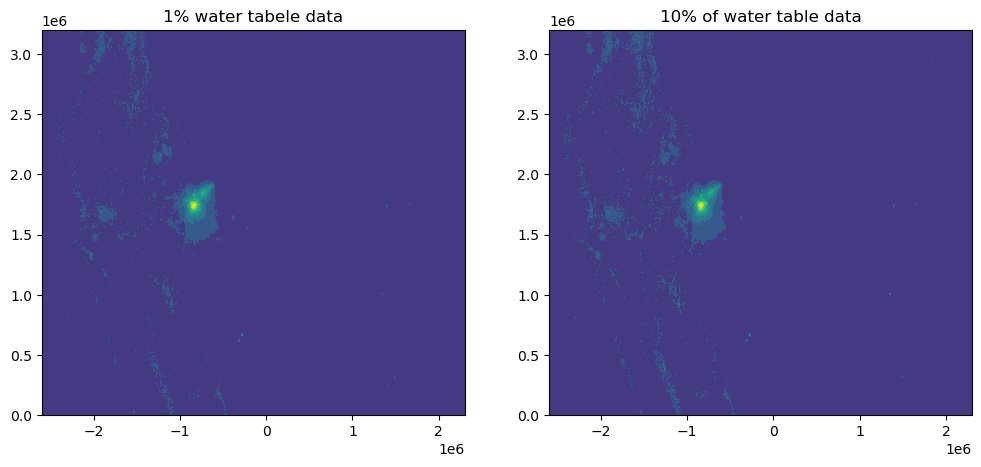

In [64]:

#snwer below
from IPython import display
import time

fig,ax=plt.subplots(1,2,figsize=(12,5), sharex=True)

ax[0].contourf(x, y, WT_LOW)
ax[0].set_title('1% water tabele data')

ax[1].contourf(x, y, WT_LOW2)
ax[1].set_title('10% of water table data')

Now we will compare the original 2D data set with the Fourier compressed data


Text(0.5, 1.0, 'Original data')

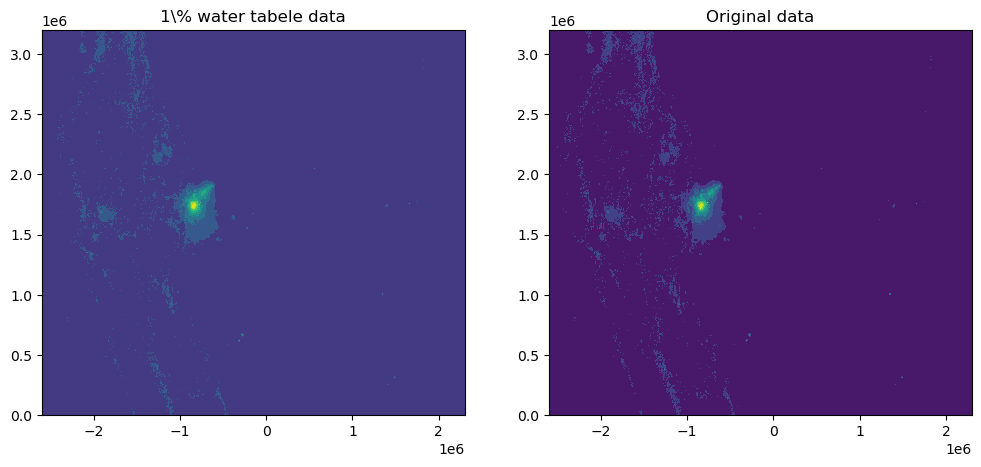

In [65]:
# answer below
fig,ax=plt.subplots(1,2,figsize=(12,5), sharex=True)

ax[0].contourf(x, y, WT_LOW)
ax[0].set_title('1\% water tabele data')

ax[1].contourf(x, y, WT)
ax[1].set_title('Original data')